In [1]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from PIL import UnidentifiedImageError

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import UnidentifiedImageError

# Define paths
main_dataset_dir = 'Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'
augmented_train_dir = 'dataset_5/augmented_train'

 

In [ ]:
# Create directories if they don't exist
os.makedirs(augmented_train_dir, exist_ok=True)

# List all classes, ignoring hidden files
classes = [d for d in os.listdir(main_dataset_dir) if os.path.isdir(os.path.join(main_dataset_dir, d)) and not d.startswith('.')]

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

desired_num_images = 1000

for cls in classes:
    class_dir = os.path.join(main_dataset_dir, cls)
    augmented_train_class_dir = os.path.join(augmented_train_dir, cls)
    
    os.makedirs(augmented_train_class_dir, exist_ok=True)
    
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    if not images:
        print(f"No images found for class {cls}. Skipping...")
        continue
    
    # Split data: 100% for augmentation
    train_images = images
    
    def generate_augmented_images(image_list, target_dir, required_images):
        """Generates augmented images to reach the required total count."""
        for img_name in image_list:
            img_path = os.path.join(class_dir, img_name)
            try:
                img = load_img(img_path, target_size=(128, 128))   # Adjust the target size as needed
                x = img_to_array(img)  
                x = x.reshape((1,) + x.shape)  
                
                # Calculate number of augmentations needed per original image
                num_augmented_samples = max((required_images - len(image_list)) // len(image_list), 0)
                
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=target_dir, save_prefix='aug', save_format='jpg'):
                    i += 1
                    if i >= num_augmented_samples:
                        break  
            except UnidentifiedImageError:
                print(f"Cannot identify image file {img_path}. Skipping...")

    # Generate augmented images for training set
    generate_augmented_images(train_images, augmented_train_class_dir, desired_num_images)
    
    # Copy remaining original images to the training set if needed to reach desired count
    current_train_images = len(os.listdir(augmented_train_class_dir))
    if current_train_images < desired_num_images:
        for img_name in train_images:
            img_path = os.path.join(class_dir, img_name)
            try:
                shutil.copy(img_path, augmented_train_class_dir)
            except Exception as e:
                print(f"Error copying image {img_path}: {e}")

print("Augmented training data generation complete.")


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
augmented_train_dir = 'dataset_5/augmented_train'
train_dir = 'dataset_5/train'
validation_dir = 'dataset_5/validation'

 

In [ ]:
# Create directories for training and validation if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# List all classes
classes = [d for d in os.listdir(augmented_train_dir) if os.path.isdir(os.path.join(augmented_train_dir, d)) and not d.startswith('.')]

for cls in classes:
    class_augmented_dir = os.path.join(augmented_train_dir, cls)
    class_train_dir = os.path.join(train_dir, cls)
    class_validation_dir = os.path.join(validation_dir, cls)
    
    # Create directories for each class in train and validation directories
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_validation_dir, exist_ok=True)
    
    # List all images in the class directory
    images = [f for f in os.listdir(class_augmented_dir) if os.path.isfile(os.path.join(class_augmented_dir, f))]
    
    if len(images) == 0:
        print(f"No images found in {class_augmented_dir}. Skipping...")
        continue

    print(f"Processing {len(images)} images for class {cls}.")
    
    # Split the images into training and validation sets
    try:
        train_images, validation_images = train_test_split(images, test_size=0.2, random_state=42)
    except ValueError as e:
        print(f"Error splitting images for class {cls}: {e}")
        continue
    
    # Copy training images to the train directory
    for img_name in train_images:
        src = os.path.join(class_augmented_dir, img_name)
        dst = os.path.join(class_train_dir, img_name)
        shutil.copy(src, dst)
    
    # Copy validation images to the validation directory
    for img_name in validation_images:
        src = os.path.join(class_augmented_dir, img_name)
        dst = os.path.join(class_validation_dir, img_name)
        shutil.copy(src, dst)

print("Training and validation data split complete.")


In [4]:
classes = [d for d in os.listdir(augmented_train_dir) if os.path.isdir(os.path.join(augmented_train_dir, d)) and not d.startswith('.')]


In [5]:

 
image_size = (128, 128)
batch_size = 32

In [6]:
 
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir ,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 22296 images belonging to 30 classes.
Found 5588 images belonging to 30 classes.


In [7]:
 
model = Sequential([
    Input(shape=(128, 128, 3)),   
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')
])


In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

 


In [9]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
 

In [10]:

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/Applications/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


697/697 ━━━━━━━━━━━━━━━━━━━━ 153s 218ms/step - accuracy: 0.3442 - loss: 2.2527 - val_accuracy: 0.7946 - val_loss: 0.6476
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 165s 236ms/step - accuracy: 0.7960 - loss: 0.6413 - val_accuracy: 0.9107 - val_loss: 0.2833
Epoch 3/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 168s 241ms/step - accuracy: 0.8923 - loss: 0.3262 - val_accuracy: 0.9264 - val_loss: 0.2254
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 173s 247ms/step - accuracy: 0.9274 - loss: 0.2179 - val_accuracy: 0.9288 - val_loss: 0.2296
Epoch 5/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 186s 267ms/step - accuracy: 0.9499 - loss: 0.1566 - val_accuracy: 0.9506 - val_loss: 0.1564
Epoch 6/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 195s 280ms/step - accuracy: 0.9572 - loss: 0.1333 - val_accuracy: 0.9481 - val_loss: 0.1516
Epoch 7/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 203s 290ms/step - accuracy: 0.9601 - loss: 0.1174 - val_accuracy: 0.9418 - val_loss: 0.1845
Epoch 8/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 214s 306ms/step - accuracy: 0.9662 - loss: 0.10

In [11]:
model.save('leaf_classifier_2.h5')


In [12]:
val_loss,val_accuarcy=model.evaluate(val_generator) 

175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9536 - loss: 0.1544


In [13]:
train_loss,train_accuarcy=model.evaluate(train_generator)

697/697 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.9962 - loss: 0.0148


In [14]:
print(f"Validation accuarcy:{val_accuarcy *100:.2f}%")

Validation accuarcy:95.54%


In [31]:
print(f"Validation loss:{val_loss *100:.2f}%")

Validation loss:14.60%


In [15]:
print(f"traning accuarcy:{train_accuarcy *100:.2f}%")

traning accuarcy:99.57%


In [32]:
print(f"traning loss:{train_loss *100:.2f}%")

traning loss:1.52%


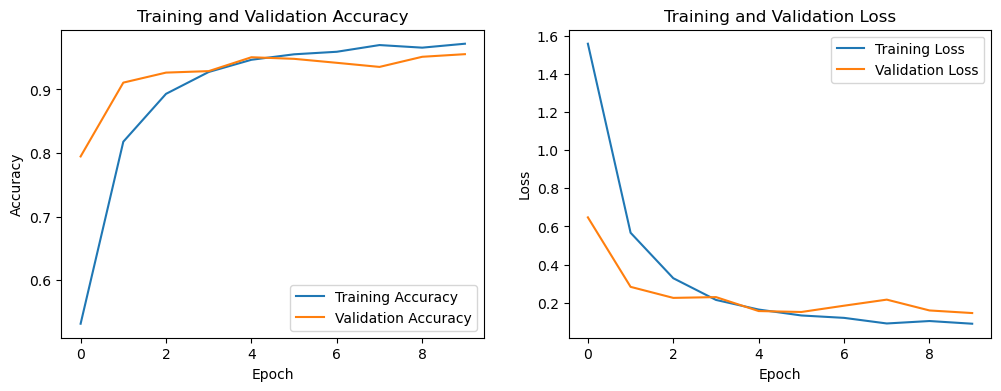

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()



In [18]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

 

In [19]:
# Define paths
validation_dir = 'dataset_5/validation'

 

In [20]:
# Define your validation data generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

 

Found 5588 images belonging to 30 classes.


In [21]:
# Predict on the validation data
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
predictions = model.predict(validation_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

 

  1/175 ━━━━━━━━━━━━━━━━━━━━ 36s 208ms/step

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step


In [22]:
# Convert true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

 

In [23]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.98      0.92      0.95       189
            Amaranthus Viridis (Arive-Dantu)       0.89      0.89      0.89       190
        Artocarpus Heterophyllus (Jackfruit)       0.99      0.99      0.99       180
                   Azadirachta Indica (Neem)       0.97      0.96      0.96       185
                       Basella Alba (Basale)       0.93      0.96      0.94       178
            Brassica Juncea (Indian Mustard)       0.98      0.98      0.98       190
                  Carissa Carandas (Karanda)       0.96      0.92      0.94       186
                        Citrus Limon (Lemon)       0.99      0.86      0.92       187
             Ficus Auriculata (Roxburgh fig)       0.90      0.96      0.93       189
               Ficus Religiosa (Peepal Tree)       1.00      1.00      1.00       182
                      Hibiscus Rosa-sinensis       0.

In [24]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


In [25]:
model = load_model('leaf_classifier_2.h5')


In [26]:
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image
        return img_array
    except UnidentifiedImageError:
        print("Error: The image at the specified path could not be identified.")
        return None


In [27]:
def predict_leaf_name(image_path, model, class_indices):
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        return
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}   
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label


In [28]:
class_indices = train_generator.class_indices


In [29]:
image_path = 'dataset_5/validation/Basella Alba (Basale)/aug_0_1613.jpg'
predicted_leaf_name = predict_leaf_name(image_path, model, class_indices)
print(f"Predicted Leaf Name: {predicted_leaf_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Leaf Name: Basella Alba (Basale)


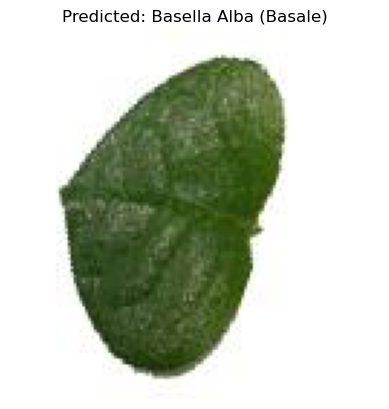

In [30]:
 
def plot_image_with_prediction(image_path, predicted_label):
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

plot_image_with_prediction(image_path, predicted_leaf_name)